In [1]:
import json

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
dataset = 'dynamic_data.json'
model_save_path = 'point_history_classifier.hdf5'

In [3]:
NUM_CLASSES = 4

In [4]:
TIME_STEPS = 16
DIMENSION = 2

In [ ]:
data = None
with open(dataset,'r') as f:
  data = json.load(f)


In [10]:
classNames = list(data.keys())
classNames

['stop', 'clockwise', 'anticlockwise', 'linear_moving']

In [11]:
classNameMap = {}

for ind,i in enumerate(classNames):
  classNameMap[i] = ind

{'anticlockwise': 2, 'clockwise': 1, 'linear_moving': 3, 'stop': 0}

In [13]:
x_ = []
y_ = []

for l in classNames:
  temp_x = data[l]
  temp_y = [classNameMap[l] for i in range(len(temp_x))]
  x_.extend(temp_x)
  y_.extend(temp_y)

In [15]:
len(x_),len(y_)

(4004, 4004)

In [16]:
X_dataset = np.array(x_).astype(np.float32)

In [17]:
y_dataset = np.array(y_).astype(np.float32)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [47]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [48]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 24)                792       
                                                                 
 dropout_7 (Dropout)         (None, 24)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                250       
                                                                 
 dense_9 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1,086
Trainable params: 1,086
Non-trainable params: 0
_________________________________________________________________


In [49]:

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [50]:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
tf.__version__

'2.8.0'

In [51]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
22/24 [==========================>...] - ETA: 0s - loss: 1.3763 - accuracy: 0.4190
Epoch 1: saving model to point_history_classifier.hdf5
24/24 [==============================] - 1s 9ms/step - loss: 1.3760 - accuracy: 0.4189 - val_loss: 1.3731 - val_accuracy: 0.5145
Epoch 2/1000
21/24 [=========================>....] - ETA: 0s - loss: 1.3663 - accuracy: 0.4438
Epoch 2: saving model to point_history_classifier.hdf5
24/24 [==============================] - 0s 5ms/step - loss: 1.3659 - accuracy: 0.4399 - val_loss: 1.3625 - val_accuracy: 0.5055
Epoch 3/1000
23/24 [===========================>..] - ETA: 0s - loss: 1.3557 - accuracy: 0.4562
Epoch 3: saving model to point_history_classifier.hdf5
24/24 [==============================] - 0s 5ms/step - loss: 1.3553 - accuracy: 0.4572 - val_loss: 1.3502 - val_accuracy: 0.5025
Epoch 4/1000
22/24 [==========================>...] - ETA: 0s - loss: 1.3472 - accuracy: 0.4499
Epoch 4: saving model to point_history_classifier.hdf5
24/24 [==

In [52]:

model = tf.keras.models.load_model(model_save_path)

In [53]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[0.9185203  0.01600679 0.00590948 0.05956341]
0


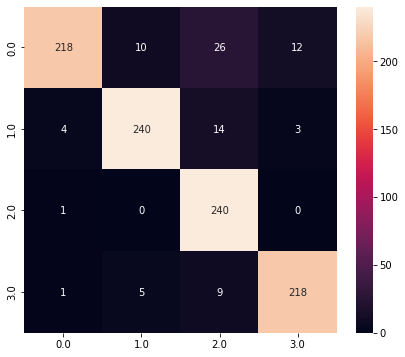

Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89       266
         1.0       0.94      0.92      0.93       261
         2.0       0.83      1.00      0.91       241
         3.0       0.94      0.94      0.94       233

    accuracy                           0.92      1001
   macro avg       0.92      0.92      0.92      1001
weighted avg       0.92      0.92      0.91      1001



In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [55]:
model = tf.keras.models.load_model(model_save_path)

In [56]:
tflite_save_path = 'point_history_classifier.tflite'

In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpxh3v0r2b/assets


INFO:tensorflow:Assets written to: /tmp/tmpxh3v0r2b/assets


6320

In [58]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [59]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_4:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [60]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [61]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 386 µs, sys: 30 µs, total: 416 µs
Wall time: 332 µs


In [62]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.9185203  0.01600678 0.00590948 0.05956341]
0
